# Image Preprocessing

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from PIL import Image
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import pickle

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
torchvision.disable_beta_transforms_warning()

## CustomDataset to import dataset

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)[1:]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._get_images()
        self.class_count = self._get_class_count()
        self.images_splited_each_class = self._split_img_each_class()

    def _get_images(self):
        images = []
        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            class_idx = self.class_to_idx[cls]
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append((img_path, class_idx))
        return images
    
    def _get_class_count(self):
        class_count = {}
        for cls_name in self.class_to_idx.values():
            class_count[cls_name] = 0
        for key,value in self.images:
           class_count[value] += 1 
        return class_count
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
        return img, label
    
    def _get_labels(self):
        return [i[1] for i in self.images]
    
    def _split_img_each_class(self):
        data_class_split = {}
        for i in self.class_to_idx.values():
            data_class_split[i] = []
        for i in self.class_to_idx.values():
            for j in range(len(self.images)):
                if self.images[j][-1] == i:
                    data_class_split[i].append(self.images[j])
        return data_class_split

In [3]:
sample_data = CustomDataset(root_dir='Dataset')

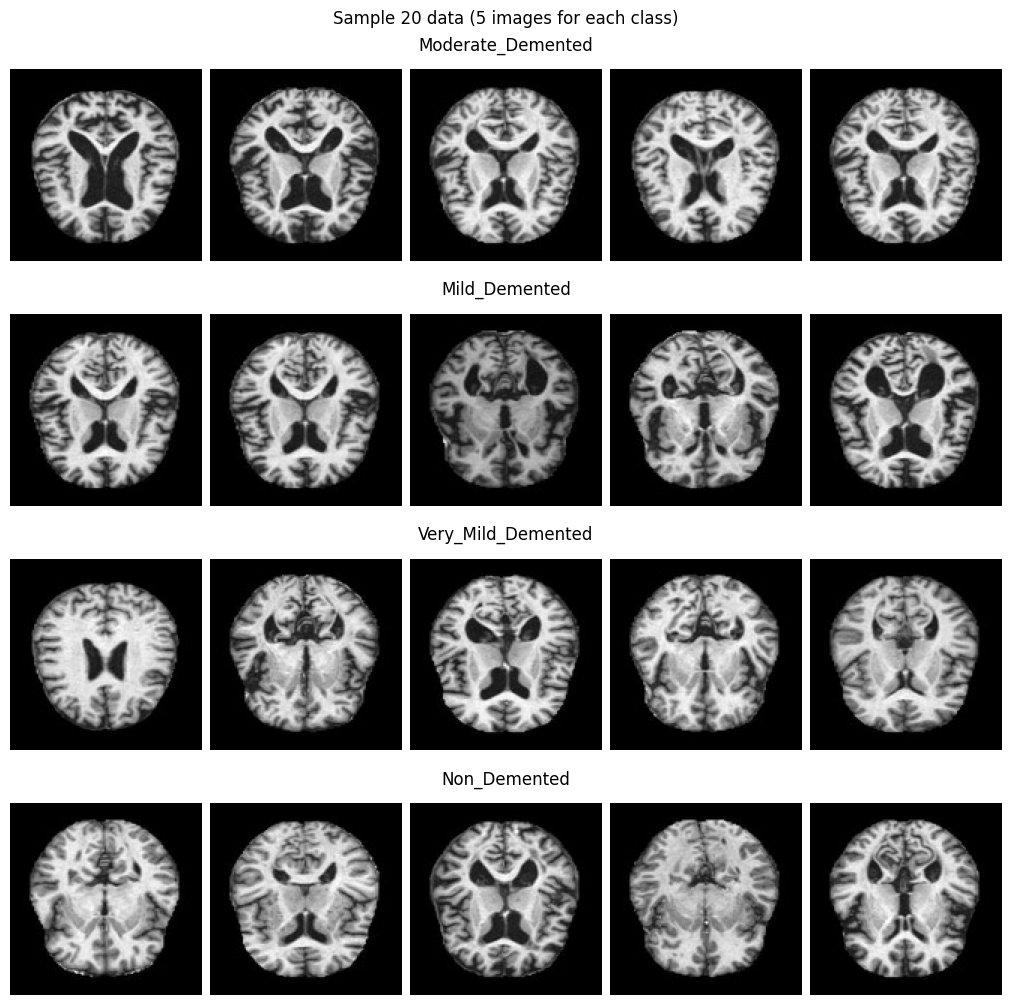

In [4]:
import matplotlib.image as mpimg
import copy

sample_data_dict = copy.deepcopy(sample_data.images_splited_each_class)

# create 4x1 subplots
fig, axs = plt.subplots(nrows=4, ncols=1, constrained_layout=True, figsize=(10, 10))
fig.suptitle('Sample 20 data (5 images for each class)')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(zip(subfigs,sample_data.classes)):
    subfig[0].suptitle(subfig[-1])

    # create 1x5 subplots per subfig
    axs = subfig[0].subplots(nrows=1, ncols=5)

    for class_label, images in sample_data_dict.items():
        for i in range(5):
            img = mpimg.imread(images[i][0])
            axs[i].imshow(img,cmap='gray')
            axs[i].axis('off')
        break
 
    del sample_data_dict[class_label]

plt.show()

## Augmentation

### AddGaussianNoise

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, probability=0.5):
        self.std = std
        self.mean = mean
        self.probability = probability
        
    def __call__(self, tensor):
        if random.random() < self.probability:
            return tensor + (torch.randn(tensor.size()) * self.std) + self.mean
        else:
            return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

### Contrast-limited Adaptive Histogram Equalization (CLAHE)

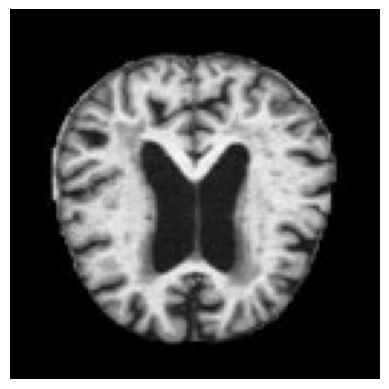

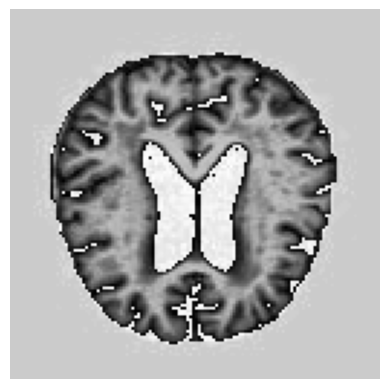

In [6]:
# Reading the image from the present directory
image = cv2.imread('Dataset/Mild_Demented/mild_2.jpg')
# Resizing the image for compatibility

# The initial processing of the image
# image = cv2.medianBlur(image, 3)
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit=3,tileGridSize=(1,1))
final_img = clahe.apply(image_bw) + 200
 
# Showing the two images
plt.imshow(cv2.cvtColor(image_bw, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [7]:
import cv2

class AddCLAHE():
    def __init__(self, clipLimit=3, tileGridSize=(1, 1), threshold=200) -> None:
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
        self.threshold = threshold

    def __call__(self, tensor):
        tensor = tensor.numpy() * 255 
        tensor = tensor.astype('uint8')[0]

        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        transformed_tensor = clahe.apply(tensor)
        transformed_tensor = torch.from_numpy(transformed_tensor).float() + self.threshold
        transformed_tensor = transformed_tensor / 255
        transformed_tensor = transformed_tensor.unsqueeze(0)

        return transformed_tensor

    def __repr__(self):
        return self.__class__.__name__ + '(clipLimit={}, tileGridSize={}, threshold={})'.format(
            self.clipLimit, self.tileGridSize, self.threshold
        )

### Split white and gray matter

In [4]:
class split_white_and_gray():
    def __init__(self,threshold=120) -> None:
        self.threshold = threshold

    def __call__(self,tensor):
        tensor = (tensor*255).to(torch.int64)

        # Apply thresholding
        gray_matter = torch.where(tensor >= self.threshold,tensor,0)
        gray_matter = (gray_matter/255).to(torch.float64)
        white_matter = torch.where(tensor < self.threshold,tensor,0)
        white_matter = (white_matter/255).to(torch.float64)
        tensor = (tensor/255).to(torch.float64)

        return torch.cat((gray_matter, white_matter,tensor), dim=0)

# Prepare Dataset 

## Data transforms

In [9]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    split_white_and_gray(120),
    #AddCLAHE(),
    #AddGaussianNoise(0,0.05), 
])

In [10]:
#Dataset = CustomDataset(root_dir='Dataset', transform=transform)

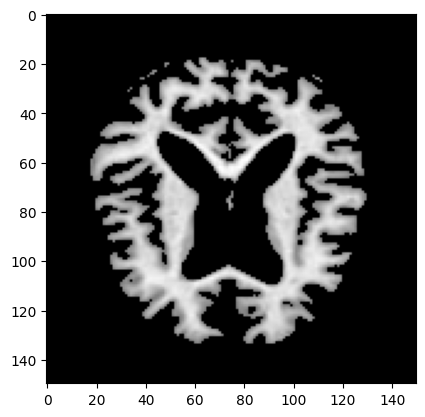

In [11]:
plt.imshow(transforms.ToPILImage()(Dataset[0][0][0]),cmap='gray')
plt.show()

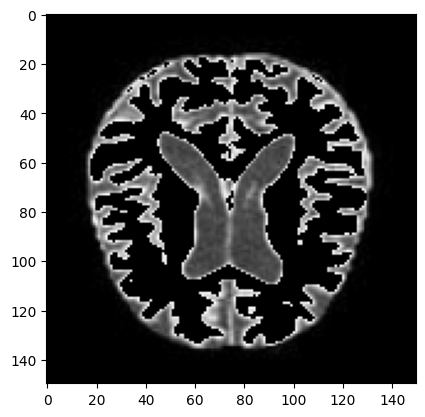

In [12]:
plt.imshow(transforms.ToPILImage()(Dataset[0][0][1]),cmap='gray')
plt.show()

## Split dataset 

In [13]:
from torch.utils.data import random_split

# Assuming you have a dataset named 'dataset' and it contains your data
dataset_size = len(Dataset)
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)  # 15% for validation
test_size = dataset_size - train_size - val_size  # Remaining 15% for testing

train_dataset, val_test_dataset = random_split(Dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

## Over sampling method

In [5]:
def OverSample(Dataset):
    data = list(Dataset)
    class_count = {0:0, 1:0, 2:0, 3:0}
    for _, class_name in data:
        class_count[class_name] += 1

    # Calculate class weights for oversampling
    class_counts = list(class_count.values())
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

    # Assign weights to each sample based on its class
    
    weights = [class_weights[label] for _, label in data]

    # Create a WeightedRandomSampler to oversample minority classes
    sampler = WeightedRandomSampler(weights, 10000, replacement=True)

    return sampler

## Apply DataLoader

In [15]:
batch_size=64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=OverSample(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, sampler=OverSample(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,)

In [16]:
class_counts = {label: 0 for label in range(len(Dataset.classes))}

# Iterate through the DataLoader
for _, labels in train_dataloader:
    for label in labels:
        class_counts[label.item()] += 1

# Print the counts
for label, count in class_counts.items():
    print(f"Class {label}: {count} items")

Class 0: 2482 items
Class 1: 2580 items
Class 2: 2425 items
Class 3: 2513 items


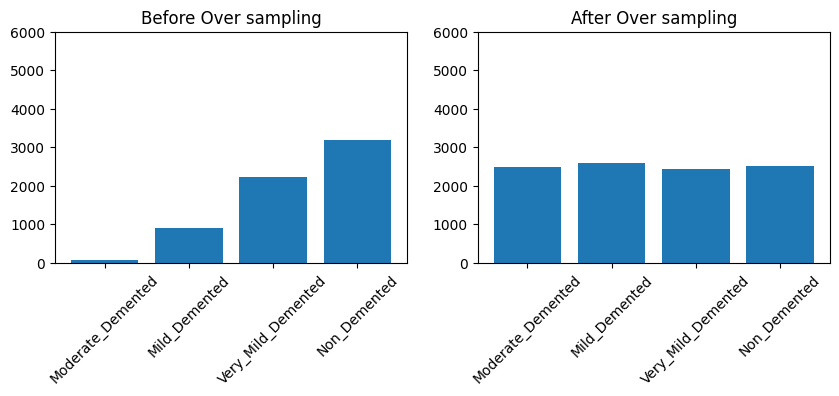

In [17]:
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))  # Adjust the figsize as needed

# Add the first subplot
ax1.bar(Dataset.classes, Dataset.class_count.values())
ax1.set_xticks(range(len(Dataset.classes)))
ax1.set_xticklabels(Dataset.classes, rotation=45)
ax1.set_ylim(top=6000)
ax1.set_title("Before Over sampling")

# Add the second subplot
ax2.bar(Dataset.classes, class_counts.values())
ax2.set_xticks(range(len(Dataset.classes)))
ax2.set_xticklabels(Dataset.classes, rotation=45)
ax2.set_ylim(top=6000)
ax2.set_title("After Over sampling")

plt.show()


## visualization of each class

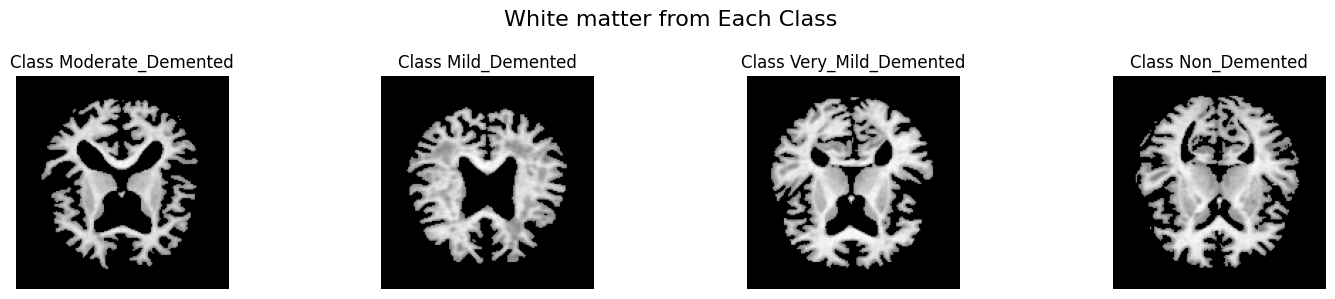

In [18]:
images, labels = next(iter(train_dataloader))

img_index = []
for label in labels.unique():
    img_index.append(list(labels).index(label))

image_each_classes = []
for idx in img_index:
    image_each_classes.append(images[idx])

# Plot one image from each class
fig, axs = plt.subplots(1, len(Dataset.classes), figsize=(15, 3))
fig.suptitle("White matter from Each Class", fontsize=16)

for class_num, i in enumerate(zip(Dataset.classes,image_each_classes)):
    axs[class_num].imshow(transforms.ToPILImage()(i[-1][0]),cmap='gray')
    axs[class_num].set_title(f"Class {i[0]}")
    axs[class_num].axis('off')

plt.tight_layout()
plt.show()

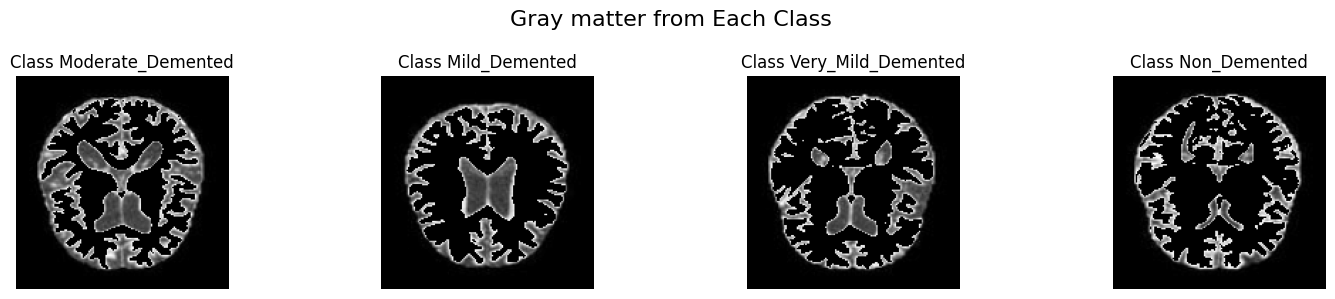

In [19]:
# Plot one image from each class
fig, axs = plt.subplots(1, len(Dataset.classes), figsize=(15, 3))
fig.suptitle("Gray matter from Each Class", fontsize=16)

for class_num, i in enumerate(zip(Dataset.classes,image_each_classes)):
    axs[class_num].imshow(transforms.ToPILImage()(i[-1][1]),cmap='gray')
    axs[class_num].set_title(f"Class {i[0]}")
    axs[class_num].axis('off')

plt.tight_layout()
plt.show()

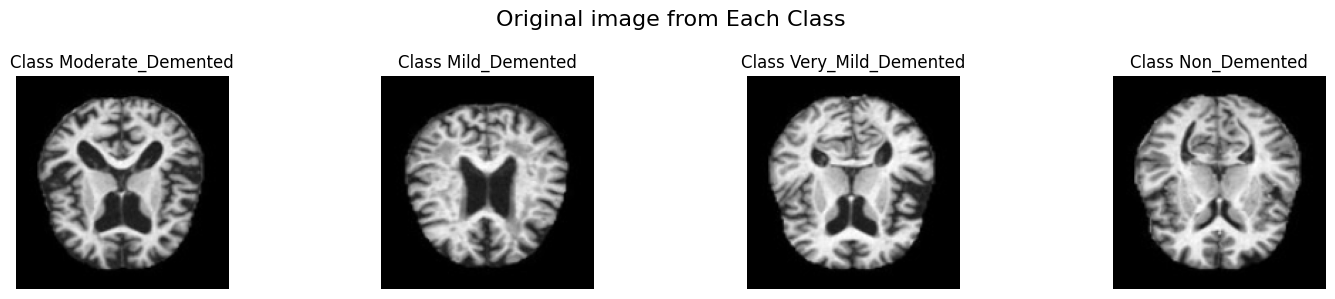

In [20]:
# Plot one image from each class
fig, axs = plt.subplots(1, len(Dataset.classes), figsize=(15, 3))
fig.suptitle("Original image from Each Class", fontsize=16)

for class_num, i in enumerate(zip(Dataset.classes,image_each_classes)):
    axs[class_num].imshow(transforms.ToPILImage()(i[-1][2]),cmap='gray')
    axs[class_num].set_title(f"Class {i[0]}")
    axs[class_num].axis('off')

plt.tight_layout()
plt.show()

# Model Training

class names : https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json,
https://github.com/anishathalye/imagenet-simple-labels/blob/master/imagenet-simple-labels.json

In [21]:
import requests

# Fetch the ImageNet class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(LABELS_URL)
labels = response.json()

labels[:10]

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

## Train Function

In [5]:
from torch.optim import lr_scheduler
import tqdm.notebook as tq
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import accuracy_score

def train(model:models, traindata:DataLoader, valdata:DataLoader, device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")) -> tuple:
    # training
    # Loop for training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    num_epochs = 50
    train_loss_history = []
    train_accuracy_history = []
    validation_loss_history = []
    validation_accuracy_history = []

    for epoch in tq.tqdm(range(num_epochs), desc="Epoch num", position=0, leave=True):
        # Train set
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        # Val set
        val_running_loss = 0.0
        val_all_labels = []
        val_all_predictions = []

        # Use tqdm for progress visualization
        for i, data in enumerate(zip(traindata, valdata)):
            model.train()#change mode to training

            train_set, val_set = data
            inputs, labels = train_set

            optimizer.zero_grad()

            # Move inputs and labels to device
            inputs, labels = inputs.to(torch.float32).to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

            # Track predictions for accuracy calculation
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            # Accumulate the loss
            running_loss += loss.item()
    #################################################################################################        
            # loss and acc on validation set
            model.eval() #change mode to evaluation
            with torch.no_grad():
                val_inputs, val_labels = val_set
                val_inputs, val_labels = val_inputs.to(torch.float32).to(device), val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_predictions = torch.max(val_outputs, 1)
                val_all_labels.extend(val_labels.cpu().numpy())
                val_all_predictions.extend(val_predictions.cpu().numpy())

                val_running_loss += val_loss.item()
    #################################################################################################
        scheduler.step()

        # Calculate accuracy on training set
        accuracy = accuracy_score(all_labels, all_predictions)
        average_train_loss = running_loss / len(train_dataloader)
        train_loss_history.append(average_train_loss)
        train_accuracy_history.append(accuracy)

        # Calculate accuracy on validation set
        val_accuracy = accuracy_score(val_all_labels, val_all_predictions)
        average_validation_loss = val_running_loss / len(val_dataloader)
        validation_loss_history.append(average_validation_loss)
        validation_accuracy_history.append(val_accuracy)
        
        # Print statistics for the epoch
        print("-------------------------------------------------------------------")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Training Loss   : {average_train_loss:.3f}  |  Training Accuracy   : {accuracy:.3f}")
        print(f"Validation Loss : {average_validation_loss:.3f}  |  Validation Accuracy : {val_accuracy:.3f}")
        print("-------------------------------------------------------------------")
        print()
    
    return train_loss_history, train_accuracy_history, validation_loss_history, validation_accuracy_history

## ResNet18

### Transfer

In [23]:
import torch.nn as nn
import torchvision.models as models
import collections
import torch.optim as optim
from sklearn.metrics import accuracy_score

class Resnet18_backbone(nn.Module):
    def __init__(self):
        super(Resnet18_backbone, self).__init__()
        self.numclass =  4
        self.resnet18 = models.resnet18()
        self.resnet18_removelast = nn.Sequential(*list(self.resnet18.children())[:-1])
        self.classification_head = nn.Sequential(
                                                    nn.Linear(512, 256),  # Linear layer
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(256, 128),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(128, self.numclass),
                                                    nn.Softmax(dim=1),
                                                )
        self.resnet18_backbone = nn.Sequential(
                                                    collections.OrderedDict(
                                                        [
                                                            ("resnet18", self.resnet18_removelast),
                                                            ("Flatten", nn.Flatten()),  # Flatten the output
                                                            ("Head", self.classification_head),
                                                        ]
                                                    )
                                                )
        
    def forward(self, x):
        return self.resnet18_backbone(x)
    

In [24]:
# Move the model to device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
resnet18 = Resnet18_backbone().to(torch.float32).to(device)

### Draw graph

In [25]:
# from torchviz import make_dot

# # Generate a visual representation of the model's computational graph
# x = torch.randn(1, 3, 150, 150)  # Example input
# y = resnet18_backbone(x)
# dot = make_dot(y, params=dict(resnet18.named_parameters()))

# # Save the generated graph as an image
# dot.render("your_model_graph")

### training

In [26]:
train_loss, train_acc, val_loss, val_acc = train(resnet18,train_dataloader,val_dataloader)

Epoch num:   0%|          | 0/50 [00:00<?, ?it/s]

-------------------------------------------------------------------
Epoch 1/50
Training Loss   : 1.088  |  Training Accuracy   : 0.645
Validation Loss : 1.318  |  Validation Accuracy : 0.410
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 2/50
Training Loss   : 1.021  |  Training Accuracy   : 0.714
Validation Loss : 1.181  |  Validation Accuracy : 0.553
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 3/50
Training Loss   : 0.967  |  Training Accuracy   : 0.771
Validation Loss : 1.109  |  Validation Accuracy : 0.626
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 4/50
Training Loss   : 0.947  |  Training Accuracy   : 0.792
Validation Loss : 1.159  |  Validation Accuracy : 0.578
-----------------------------

### Loss and Acc on Training

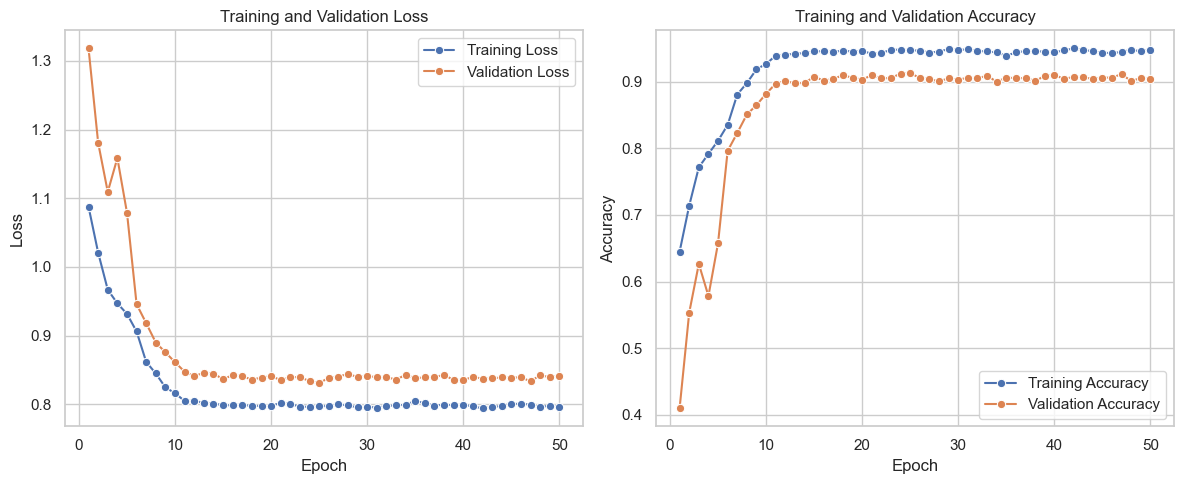

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the seaborn style
sns.set(style="whitegrid")

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the Loss
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss', marker='o', ax=axes[0])
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss', marker='o', ax=axes[0])
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting the Accuracy
sns.lineplot(x=range(1, len(train_acc) + 1), y=train_acc, label='Training Accuracy', marker='o', ax=axes[1])
sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy', marker='o', ax=axes[1])
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


#### On testset

In [28]:
import torch
from sklearn.metrics import accuracy_score

resnet18.eval()
test_all_labels = []
test_all_predictions = []
test_running_loss = 0.0

criterion = nn.CrossEntropyLoss()

for test_inputs, test_labels in tq.tqdm_notebook(test_dataloader):
    with torch.no_grad():
        test_inputs, test_labels = test_inputs.to(torch.float32).to(device), test_labels.to(device)

        test_outputs = resnet18(test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_predictions = torch.max(test_outputs, 1)
        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_predictions.extend(test_predictions.cpu().numpy())

        test_running_loss += test_loss.item()

# Calculate accuracy after the loop
test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
average_test_loss = test_running_loss / len(test_dataloader)


  0%|          | 0/15 [00:00<?, ?it/s]

### Summary

In [29]:
import pandas as pd
df = pd.DataFrame({'Loss':[train_loss[-1],val_loss[-1],average_test_loss], 
                   'Accuracy':[train_acc[-1]*100, val_acc[-1]*100, test_accuracy*100]})
df = df.set_axis(['Train', 'Validation', 'Test'])
df

,Loss,Accuracy
Train,0.796409,94.79
Validation,0.841778,90.34
Test,0.918096,82.50


In [40]:
history = pd.DataFrame({'Train Loss':train_loss,'Validation Loss':val_loss,'Train Accuracy':train_acc,'Validation Accuracy':val_acc})
history.tail(5)

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
45,0.800784,0.839625,0.9426,0.9057
46,0.799878,0.833419,0.9445,0.9115
47,0.795954,0.842644,0.9477,0.9004
48,0.798385,0.839541,0.9454,0.9057
49,0.796409,0.841778,0.9479,0.9034


### Save model

In [31]:
#torch.save(resnet18, "resnet18.pth")

## GoogLeNet

### Transfer 
Avialiable to train on CPU or GPU only. MPS is NOT supported.

In [45]:
import warnings
import pickle
warnings.filterwarnings("ignore")

Dataset = pickle.load(open('Data variable/Dataset.pkl', 'rb'))
train_dataloader = pickle.load(open('Data variable/train_dataloader.pkl', 'rb'))
test_dataloader = pickle.load(open('Data variable/test_dataloader.pkl', 'rb'))
val_dataloader = pickle.load(open('Data variable/val_dataloader.pkl', 'rb'))

In [46]:
class GoogLeNet_backbone(nn.Module):
    def __init__(self):
        super(GoogLeNet_backbone, self).__init__()
        self.numclass =  4
        self.googlenet = models.googlenet()
        self.googlenet.fc = nn.Identity()
        self.classification_head = nn.Sequential(
                                                    nn.Linear(1024, 512),  # Linear layer
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(512, 256),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(256, self.numclass),
                                                    nn.Softmax(dim=1),
                                                )
        
    def forward(self, x):
        if self.training:
            x = self.googlenet(x)
            x = self.classification_head(x.logits)
        else:
            x = self.googlenet(x)
            x = self.classification_head(x)
        return x

In [24]:
googlenet =  GoogLeNet_backbone().to(torch.float32).to(torch.device('cpu'))

### Training

In [25]:
train_loss, train_acc, val_loss, val_acc = train(googlenet,train_dataloader,val_dataloader,device=torch.device('cpu'))

Epoch num:   0%|          | 0/50 [00:00<?, ?it/s]

-------------------------------------------------------------------
Epoch 1/50
Training Loss   : 1.148  |  Training Accuracy   : 0.574
Validation Loss : 1.366  |  Validation Accuracy : 0.339
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 2/50
Training Loss   : 1.089  |  Training Accuracy   : 0.641
Validation Loss : 1.281  |  Validation Accuracy : 0.448
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 3/50
Training Loss   : 1.070  |  Training Accuracy   : 0.664
Validation Loss : 1.267  |  Validation Accuracy : 0.460
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 4/50
Training Loss   : 1.056  |  Training Accuracy   : 0.678
Validation Loss : 1.289  |  Validation Accuracy : 0.442
-----------------------------

In [28]:
import pandas as pd
history = pd.DataFrame({'Train Loss':train_loss,'Validation Loss':val_loss,'Train Accuracy':train_acc,'Validation Accuracy':val_acc})
history.tail(5)

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
45,0.890515,1.012029,0.8542,0.7280
46,0.885197,1.016205,0.8584,0.7222
47,0.886951,1.004882,0.8561,0.7321
48,0.888710,1.005677,0.8552,0.7339
49,0.888072,1.007008,0.8573,0.7324


In [31]:
import torch
from sklearn.metrics import accuracy_score

googlenet.eval()
test_all_labels = []
test_all_predictions = []
test_running_loss = 0.0

criterion = nn.CrossEntropyLoss()

for test_inputs, test_labels in tq.tqdm_notebook(test_dataloader):
    with torch.no_grad():
        test_inputs, test_labels = test_inputs.to(torch.float32).to("cpu"), test_labels.to("cpu")

        test_outputs = googlenet(test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_predictions = torch.max(test_outputs, 1)
        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_predictions.extend(test_predictions.cpu().numpy())

        test_running_loss += test_loss.item()

# Calculate accuracy after the loop
test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
average_test_loss = test_running_loss / len(test_dataloader)

  0%|          | 0/15 [00:00<?, ?it/s]

In [32]:
import pandas as pd
df = pd.DataFrame({'Loss':[train_loss[-1],val_loss[-1],average_test_loss], 
                   'Accuracy':[train_acc[-1]*100, val_acc[-1]*100, test_accuracy*100]})
df = df.set_axis(['Train', 'Validation', 'Test'])
df

,Loss,Accuracy
Train,0.888072,85.730000
Validation,1.007008,73.240000
Test,1.023340,72.083333


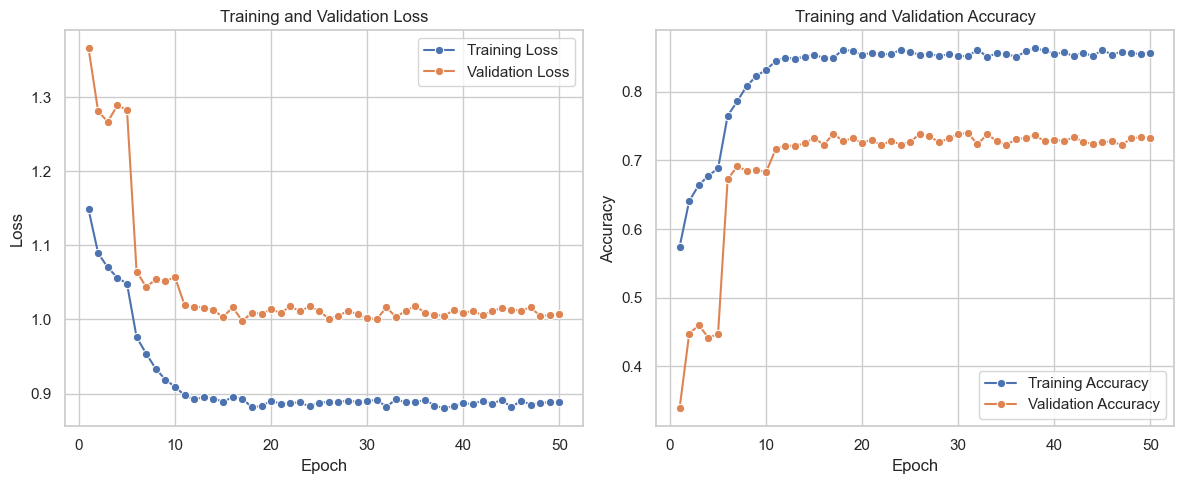

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the seaborn style
sns.set(style="whitegrid")

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the Loss
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss', marker='o', ax=axes[0])
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss', marker='o', ax=axes[0])
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting the Accuracy
sns.lineplot(x=range(1, len(train_acc) + 1), y=train_acc, label='Training Accuracy', marker='o', ax=axes[1])
sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy', marker='o', ax=axes[1])
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


In [36]:
sum(p.numel() for p in googlenet.parameters())

12637044

## SwinTransformer

### Transfer

In [58]:
import collections
import torch.nn as nn
import torchvision.models as models

class Swintransformer_backbone(nn.Module):
    def __init__(self, num_classes=4):
        super(Swintransformer_backbone, self).__init__()
        self.num_classes = num_classes
        self.swintransformer = models.swin_t()
        self.swintransformer_removelast = nn.Sequential(*list(self.swintransformer.children())[:-1])
        self.classification_head = nn.Sequential(
                                                    nn.Linear(768, 512),  # Linear layer
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(512, 256),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(256, self.num_classes),
                                                    nn.Softmax(dim=1),
                                                )
        self.swintransformer_backbone = nn.Sequential(
                                                        collections.OrderedDict(
                                                            [
                                                                ("swintransformer", self.swintransformer_removelast),
                                                                ("Head", self.classification_head),
                                                            ]
                                                        )
                                                    )

    def forward(self, x):
        return self.swintransformer_backbone(x)


In [59]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
swintransformer = Swintransformer_backbone().to(torch.float32).to(device)

In [60]:
sum(p.numel() for p in swintransformer.parameters())

28814438

### Training

In [ ]:
train_loss, train_acc, val_loss, val_acc = train(swintransformer,train_dataloader,val_dataloader)

## DenseNet

### transfer

In [30]:
import pickle

Dataset = pickle.load(open('Data variable/Dataset.pkl', 'rb'))
train_dataloader = pickle.load(open('Data variable/train_dataloader.pkl', 'rb'))
test_dataloader = pickle.load(open('Data variable/test_dataloader.pkl', 'rb'))
val_dataloader = pickle.load(open('Data variable/val_dataloader.pkl', 'rb'))

In [31]:
import collections
class DenseNet121_backbone(nn.Module):
    def __init__(self):
        super(DenseNet121_backbone, self).__init__()
        self.numclass =  4
        self.DenseNet121 = models.densenet121()
        self.DenseNet121.classifier = nn.Identity()
        self.classification_head = nn.Sequential(
                                                    nn.Linear(1024, 512),  # Linear layer
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(512, 256),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(256, self.numclass),
                                                    nn.Softmax(dim=1),
                                                )
        
        self.DenseNet121_backbone = nn.Sequential(
                                                    collections.OrderedDict(
                                                        [
                                                            ("DenseNet121", self.DenseNet121),
                                                            ("Head", self.classification_head),
                                                        ]
                                                    )
                                                )
        
    def forward(self, x):
        return self.DenseNet121_backbone(x)
        

In [32]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
densenet121 =  DenseNet121_backbone().to(torch.float32).to(device)

### training

In [34]:
train_loss, train_acc, val_loss, val_acc = train(densenet121,train_dataloader,val_dataloader)

Epoch num:   0%|          | 0/50 [00:00<?, ?it/s]

-------------------------------------------------------------------
Epoch 1/50
Training Loss   : 1.122  |  Training Accuracy   : 0.604
Validation Loss : 1.348  |  Validation Accuracy : 0.378
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 2/50
Training Loss   : 1.122  |  Training Accuracy   : 0.608
Validation Loss : 1.340  |  Validation Accuracy : 0.390
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 3/50
Training Loss   : 1.051  |  Training Accuracy   : 0.685
Validation Loss : 1.274  |  Validation Accuracy : 0.460
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 4/50
Training Loss   : 1.009  |  Training Accuracy   : 0.730
Validation Loss : 1.209  |  Validation Accuracy : 0.527
-----------------------------

In [35]:
import pandas as pd
history = pd.DataFrame({'Train Loss':train_loss,'Validation Loss':val_loss,'Train Accuracy':train_acc,'Validation Accuracy':val_acc})
history.tail(5)

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
45,0.856135,1.019366,0.8870,0.7193
46,0.852690,1.019965,0.8904,0.7200
47,0.848358,1.035063,0.8952,0.7044
48,0.854132,1.028645,0.8899,0.7112
49,0.852597,1.035447,0.8918,0.7071


In [38]:
import torch
from sklearn.metrics import accuracy_score

densenet121.eval()
test_all_labels = []
test_all_predictions = []
test_running_loss = 0.0

criterion = nn.CrossEntropyLoss()

for test_inputs, test_labels in tq.tqdm_notebook(test_dataloader):
    with torch.no_grad():
        test_inputs, test_labels = test_inputs.to(torch.float32).to(device), test_labels.to(device)

        test_outputs = densenet121(test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_predictions = torch.max(test_outputs, 1)
        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_predictions.extend(test_predictions.cpu().numpy())

        test_running_loss += test_loss.item()

# Calculate accuracy after the loop
test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
average_test_loss = test_running_loss / len(test_dataloader)

  0%|          | 0/15 [00:00<?, ?it/s]

In [39]:
import pandas as pd
df = pd.DataFrame({'Loss':[train_loss[-1],val_loss[-1],average_test_loss], 
                   'Accuracy':[train_acc[-1]*100, val_acc[-1]*100, test_accuracy*100]})
df = df.set_axis(['Train', 'Validation', 'Test'])
df

,Loss,Accuracy
Train,0.852597,89.1800
Validation,1.035447,70.7100
Test,0.985582,75.3125


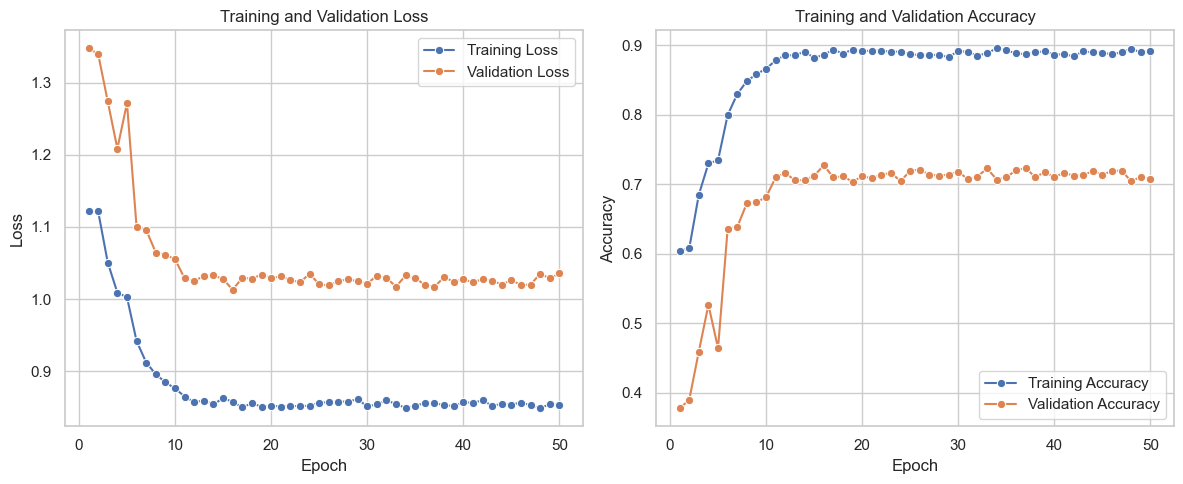

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the seaborn style
sns.set(style="whitegrid")

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the Loss
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss', marker='o', ax=axes[0])
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss', marker='o', ax=axes[0])
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting the Accuracy
sns.lineplot(x=range(1, len(train_acc) + 1), y=train_acc, label='Training Accuracy', marker='o', ax=axes[1])
sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy', marker='o', ax=axes[1])
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


In [42]:
sum(p.numel() for p in densenet121.parameters())

7611012

### save model

In [43]:
# torch.save(densenet121, "densenet121.pth")
# history.to_csv("densenet121_history.csv")
# df.to_csv("densenet121_result.csv")

## EfficientNet

### transfer

In [5]:
import pickle

Dataset = pickle.load(open('Data variable/Dataset.pkl', 'rb'))
train_dataloader = pickle.load(open('Data variable/train_dataloader.pkl', 'rb'))
test_dataloader = pickle.load(open('Data variable/test_dataloader.pkl', 'rb'))
val_dataloader = pickle.load(open('Data variable/val_dataloader.pkl', 'rb'))

In [6]:
import collections
class EfficientNet_backbone(nn.Module):
    def __init__(self):
        super(EfficientNet_backbone, self).__init__()
        self.numclass =  4
        self.EfficientNet = models.efficientnet_b2()
        self.EfficientNet.classifier = nn.Identity()
        self.classification_head = nn.Sequential(
                                                    nn.Dropout(0.3, inplace=True),
                                                    nn.Linear(1408, 512),  # Linear layer
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(512, 256),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(256, self.numclass),
                                                    nn.Softmax(dim=1),
                                                )
        
        self.EfficientNet_backbone = nn.Sequential(
                                                    collections.OrderedDict(
                                                        [
                                                            ("EfficientNet", self.EfficientNet),
                                                            ("Head", self.classification_head),
                                                        ]
                                                    )
                                                )
        
    def forward(self, x):
        return self.EfficientNet_backbone(x)
        

In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
efficientnet =  EfficientNet_backbone().to(torch.float32).to(device)

### training

In [8]:
train_loss, train_acc, val_loss, val_acc = train(efficientnet,train_dataloader,val_dataloader)

Epoch num:   0%|          | 0/50 [00:00<?, ?it/s]

-------------------------------------------------------------------
Epoch 1/50
Training Loss   : 1.231  |  Training Accuracy   : 0.465
Validation Loss : 1.341  |  Validation Accuracy : 0.335
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 2/50
Training Loss   : 1.144  |  Training Accuracy   : 0.578
Validation Loss : 1.261  |  Validation Accuracy : 0.458
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 3/50
Training Loss   : 1.085  |  Training Accuracy   : 0.647
Validation Loss : 1.160  |  Validation Accuracy : 0.569
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 4/50
Training Loss   : 1.043  |  Training Accuracy   : 0.695
Validation Loss : 1.160  |  Validation Accuracy : 0.571
-----------------------------

In [9]:
import pandas as pd
history = pd.DataFrame({'Train Loss':train_loss,'Validation Loss':val_loss,'Train Accuracy':train_acc,'Validation Accuracy':val_acc})
history.tail(5)

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
45,0.905776,1.005153,0.8367,0.7362
46,0.911898,1.015268,0.8310,0.7238
47,0.911029,1.011013,0.8320,0.7308
48,0.917739,1.009021,0.8246,0.7296
49,0.911516,1.021123,0.8297,0.7189


In [10]:
import torch
from sklearn.metrics import accuracy_score

efficientnet.eval()
test_all_labels = []
test_all_predictions = []
test_running_loss = 0.0

criterion = nn.CrossEntropyLoss()

for test_inputs, test_labels in tq.tqdm_notebook(test_dataloader):
    with torch.no_grad():
        test_inputs, test_labels = test_inputs.to(torch.float32).to(device), test_labels.to(device)

        test_outputs = efficientnet(test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_predictions = torch.max(test_outputs, 1)
        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_predictions.extend(test_predictions.cpu().numpy())

        test_running_loss += test_loss.item()

# Calculate accuracy after the loop
test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
average_test_loss = test_running_loss / len(test_dataloader)

  0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
import pandas as pd
df = pd.DataFrame({'Loss':[train_loss[-1],val_loss[-1],average_test_loss], 
                   'Accuracy':[train_acc[-1]*100, val_acc[-1]*100, test_accuracy*100]})
df = df.set_axis(['Train', 'Validation', 'Test'])
df

,Loss,Accuracy
Train,0.911516,82.970000
Validation,1.021123,71.890000
Test,1.088385,65.416667


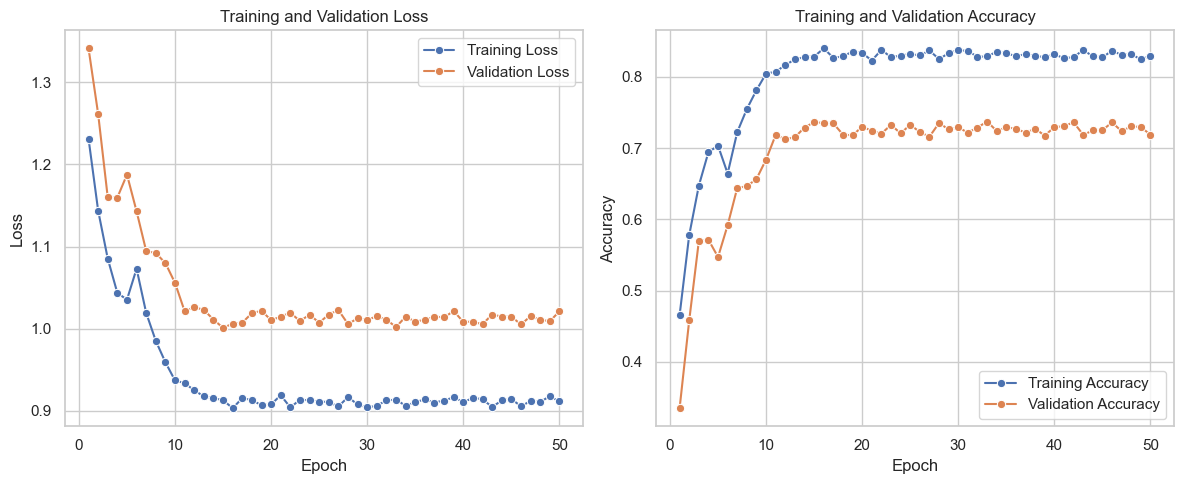

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the seaborn style
sns.set(style="whitegrid")

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the Loss
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss', marker='o', ax=axes[0])
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss', marker='o', ax=axes[0])
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting the Accuracy
sns.lineplot(x=range(1, len(train_acc) + 1), y=train_acc, label='Training Accuracy', marker='o', ax=axes[1])
sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy', marker='o', ax=axes[1])
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


In [13]:
sum(p.numel() for p in efficientnet.parameters())

8554758

### save model

In [14]:
# torch.save(efficientnet, "efficientnet_b2.pth")
# history.to_csv("efficientnet_b2_history.csv")
# df.to_csv("efficientnet_b2_result.csv")

## RegNet

### transfer

In [14]:
import pickle

Dataset = pickle.load(open('Data variable/Dataset.pkl', 'rb'))
train_dataloader = pickle.load(open('Data variable/train_dataloader.pkl', 'rb'))
test_dataloader = pickle.load(open('Data variable/test_dataloader.pkl', 'rb'))
val_dataloader = pickle.load(open('Data variable/val_dataloader.pkl', 'rb'))

In [15]:
import collections
class RegNet_backbone(nn.Module):
    def __init__(self):
        super(RegNet_backbone, self).__init__()
        self.numclass =  4
        self.regnet_y_800mf = models.regnet_y_800mf()
        self.regnet_y_800mf.fc = nn.Identity()
        self.classification_head = nn.Sequential(
                                                    nn.Linear(784, 512),  # Linear layer
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(512, 256),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(256, self.numclass),
                                                    nn.Softmax(dim=1),
                                                )
        
        self.RegNet_backbone = nn.Sequential(
                                                    collections.OrderedDict(
                                                        [
                                                            ("RegNet", self.regnet_y_800mf),
                                                            ("Head", self.classification_head),
                                                        ]
                                                    )
                                                )
        
    def forward(self, x):
        return self.RegNet_backbone(x)
        

In [16]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
regnet = RegNet_backbone().to(torch.float32).to(device)

### training

In [19]:
train_loss, train_acc, val_loss, val_acc = train(regnet,train_dataloader,val_dataloader)

Epoch num:   0%|          | 0/50 [00:00<?, ?it/s]

-------------------------------------------------------------------
Epoch 1/50
Training Loss   : 1.141  |  Training Accuracy   : 0.577
Validation Loss : 1.354  |  Validation Accuracy : 0.349
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 2/50
Training Loss   : 1.082  |  Training Accuracy   : 0.651
Validation Loss : 1.271  |  Validation Accuracy : 0.459
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 3/50
Training Loss   : 1.029  |  Training Accuracy   : 0.708
Validation Loss : 1.207  |  Validation Accuracy : 0.525
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 4/50
Training Loss   : 0.965  |  Training Accuracy   : 0.774
Validation Loss : 1.143  |  Validation Accuracy : 0.594
-----------------------------

In [20]:
import pandas as pd
history = pd.DataFrame({'Train Loss':train_loss,'Validation Loss':val_loss,'Train Accuracy':train_acc,'Validation Accuracy':val_acc})
history.tail(5)

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
45,0.836454,1.049906,0.9080,0.6935
46,0.831072,1.043346,0.9125,0.6990
47,0.826957,1.040703,0.9170,0.7012
48,0.835643,1.048094,0.9077,0.6910
49,0.831609,1.047680,0.9124,0.6937


In [21]:
import torch
from sklearn.metrics import accuracy_score

regnet.eval()
test_all_labels = []
test_all_predictions = []
test_running_loss = 0.0

criterion = nn.CrossEntropyLoss()

for test_inputs, test_labels in tq.tqdm_notebook(test_dataloader):
    with torch.no_grad():
        test_inputs, test_labels = test_inputs.to(torch.float32).to(device), test_labels.to(device)

        test_outputs = regnet(test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_predictions = torch.max(test_outputs, 1)
        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_predictions.extend(test_predictions.cpu().numpy())

        test_running_loss += test_loss.item()

# Calculate accuracy after the loop
test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
average_test_loss = test_running_loss / len(test_dataloader)

  0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
import pandas as pd
df = pd.DataFrame({'Loss':[train_loss[-1],val_loss[-1],average_test_loss], 
                   'Accuracy':[train_acc[-1]*100, val_acc[-1]*100, test_accuracy*100]})
df = df.set_axis(['Train', 'Validation', 'Test'])
df

,Loss,Accuracy
Train,0.831609,91.240000
Validation,1.047680,69.370000
Test,1.004302,73.645833


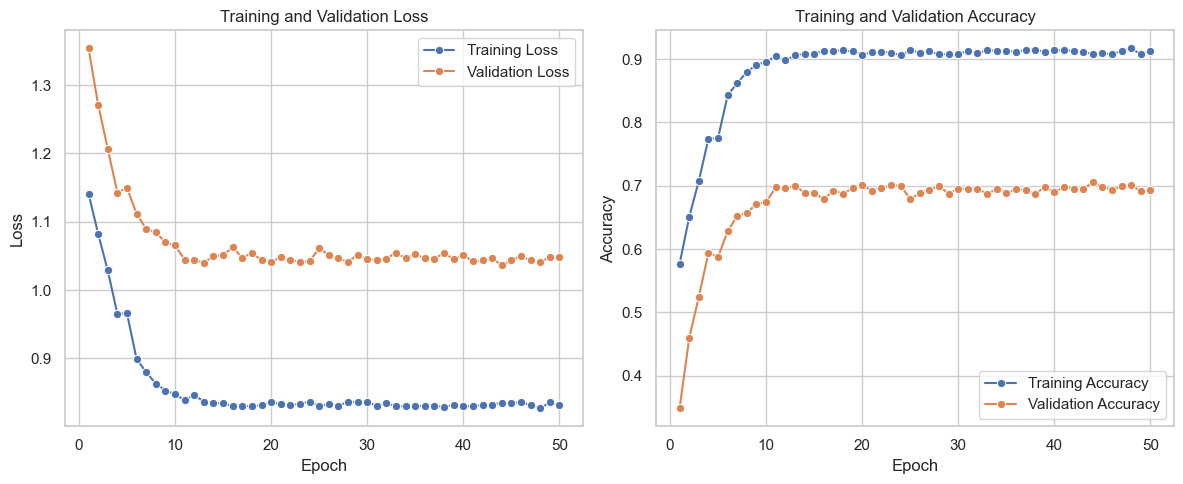

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the seaborn style
sns.set(style="whitegrid")

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the Loss
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss', marker='o', ax=axes[0])
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss', marker='o', ax=axes[0])
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting the Accuracy
sns.lineplot(x=range(1, len(train_acc) + 1), y=train_acc, label='Training Accuracy', marker='o', ax=axes[1])
sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy', marker='o', ax=axes[1])
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


In [25]:
sum(p.numel() for p in regnet.parameters())

6181788

### save model

In [26]:
# torch.save(regnet, "regnet_y_800mf.pth")
# history.to_csv("regnet_y_800mf_history.csv")
# df.to_csv("regnet_y_800mf_result.csv"